# P3 - Behavioural Cloning

## Library Imports...

In [1]:
import csv
import os
import json
import math
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.layers import Lambda

print('Done')

Using TensorFlow backend.


Done


## Step 1: Explore data sets

Plot a vertical bar chart for observation of data set. 

From the plot, we can observe the huge bias towards small angles < abs(0.1). Data set will have to be adjusted to negate the effect of the biasness.

Running data


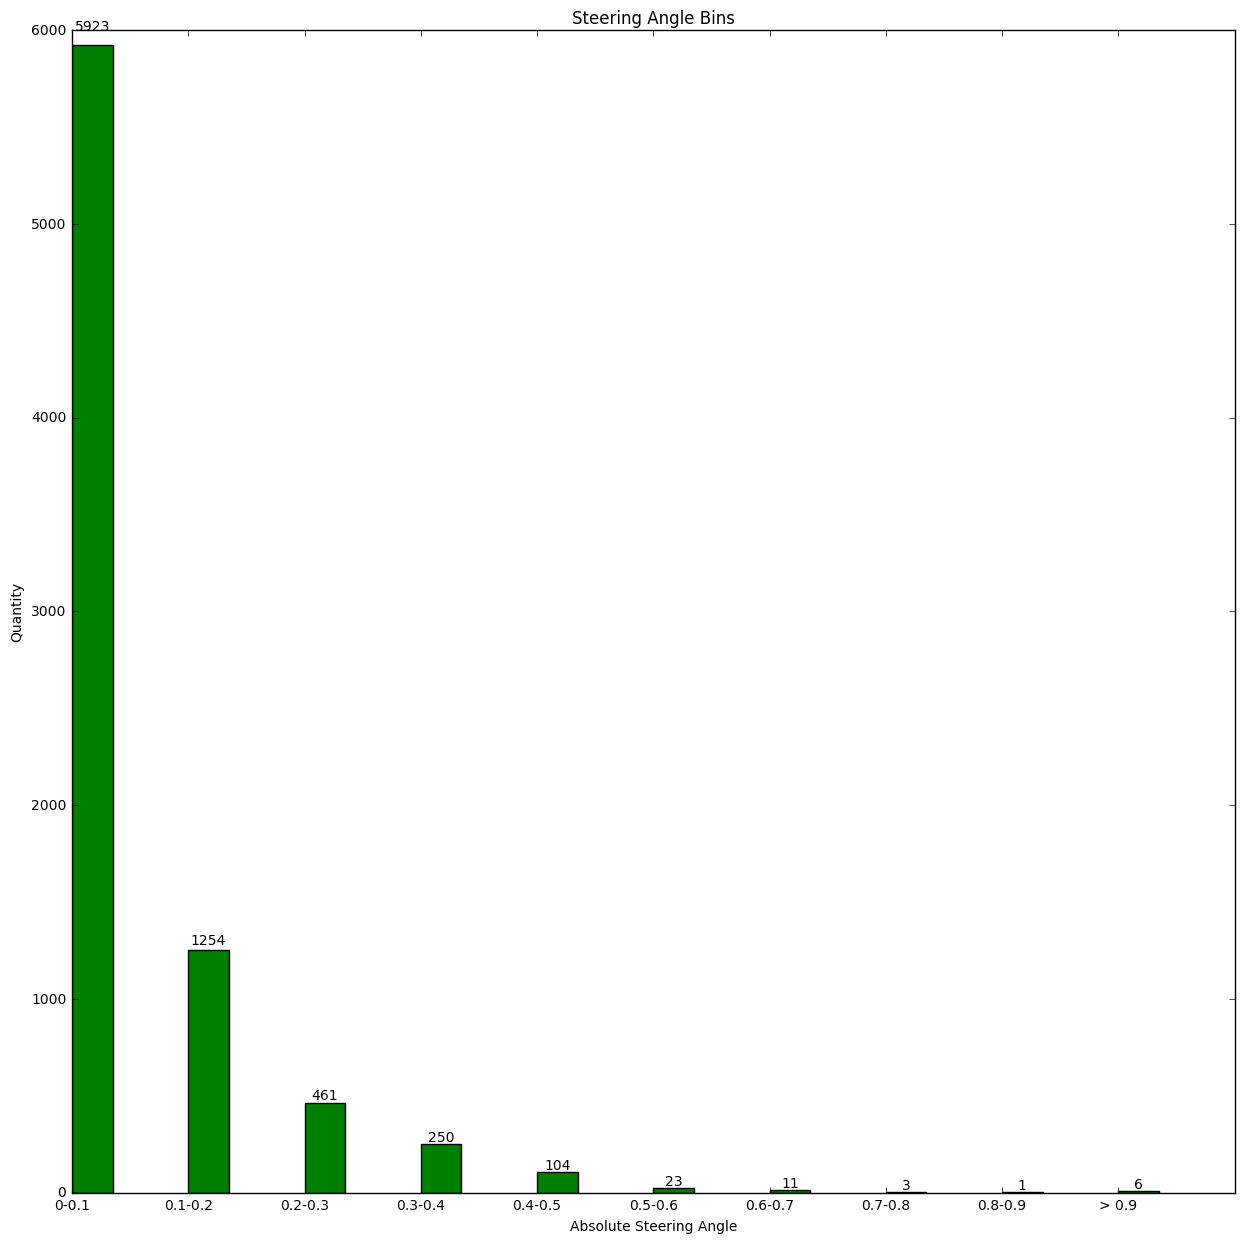

Total number of image for training: 8036
Total number of images with 0 steering angle  4361


In [2]:
# Variable to define which model and folder data is to be use for training
DATA_FOLDER = 'data'

#Read csv file and convert csv inputs into list
ifile  = open(DATA_FOLDER + '/driving_log.csv', "r")
print('Running ' + DATA_FOLDER)
reader = csv.reader(ifile)
reader = list(reader)
ifile.close()

n_zerosteering = 0
# Create 10 classes of data_types list for overview of the range of steering angles
data_types = []
for i in range(10):
    data_types.append(0)

for row in reader:
    
    if abs(float(row[3])) == 0:
        n_zerosteering += 1
    
    if abs(float(row[3])) < 0.1:
        data_types[0] += 1
    elif abs(float(row[3])) > 0.1 and abs(float(row[3])) < 0.2:
        data_types[1] += 1
    elif abs(float(row[3])) > 0.2 and abs(float(row[3])) < 0.3:
        data_types[2] += 1    
    elif abs(float(row[3])) > 0.3 and abs(float(row[3])) < 0.4:
        data_types[3] += 1        
    elif abs(float(row[3])) > 0.4 and abs(float(row[3])) < 0.5:
        data_types[4] += 1
    elif abs(float(row[3])) > 0.5 and abs(float(row[3])) < 0.6:
        data_types[5] += 1
    elif abs(float(row[3])) > 0.6 and abs(float(row[3])) < 0.7:
        data_types[6] += 1
    elif abs(float(row[3])) > 0.7 and abs(float(row[3])) < 0.8:
        data_types[7] += 1
    elif abs(float(row[3])) > 0.8 and abs(float(row[3])) < 0.9:
        data_types[8] += 1
    elif abs(float(row[3])) > 0.9:
        data_types[9] += 1

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

n_bin = len(data_types)

ind = np.arange(n_bin)
width = 0.35

bar1 = ax.bar(ind, data_types, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Quantity')
ax.set_title('Steering Angle Bins')
ax.set_xlabel('Absolute Steering Angle')
ax.set_xticks(ind)
ax.set_xticklabels(('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '> 0.9'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bar1)

plt.show()

print('Total number of image for training: ' + str(len(reader)))
print('Total number of images with 0 steering angle ', n_zerosteering)



## Step 2 : Increase data set by using left and right camera images

Data set can be increased by **3** times by using both left and right camera. For the Left and Right images, a +0.25 and -0.25 was added to the steering angle to train the model on the need to steer right when towards the left and steer left when towards the right.

Based on the graph plotted, we can see that there is a huge bias of data in the range of 0-0.1 and 0.2-0.3 due to the insertion of left and right images. 

With the larger dataset, it is important to continue to address the biasness during feeding of data for the training of model.

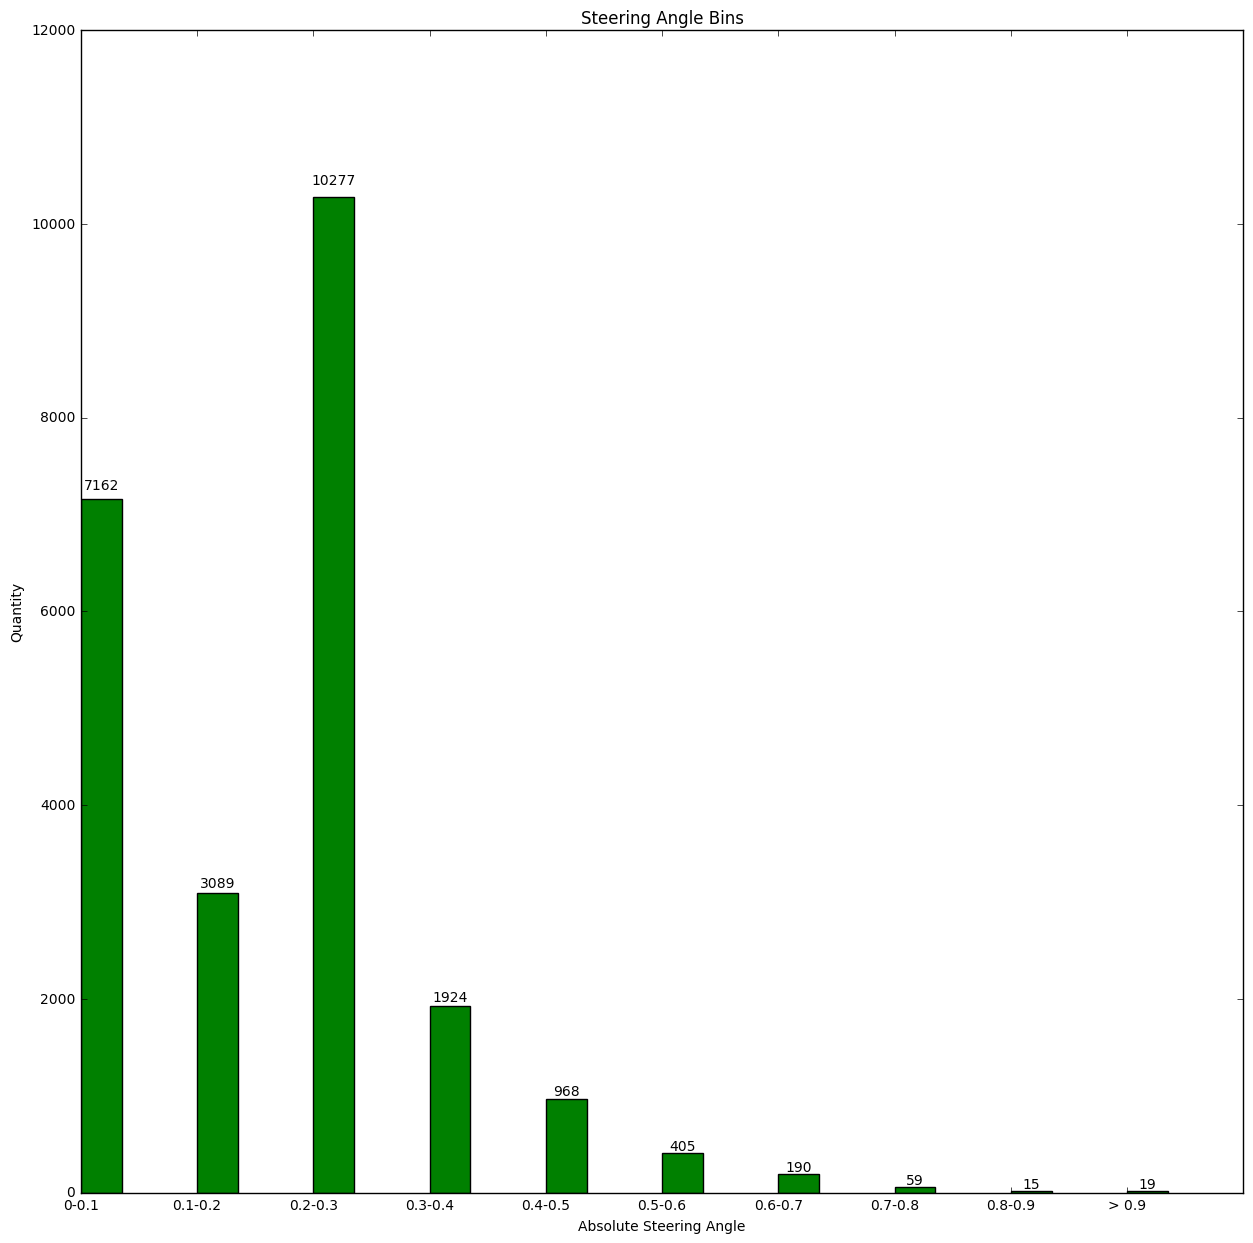

Total number of samples: 24108
Done


In [3]:
import copy

# row[3] = center image steering angle
# row[7] = left image steering angle
# row[8] = right image steering angle
# row[9] = center image flip steering angle
# row[10] = left image flip steering angle
# row[11] = right image flip steering angle

# create a copy of new reader for appending new information
new_reader = copy.deepcopy(reader)

for row in new_reader:
    row.append(float(row[3]) + 0.25)
    row.append(float(row[3]) - 0.25)
    
img_rows, img_cols, ch = 66, 200, 3

# reinitialize data_types to 0
data_types = []
for i in range(10):
    data_types.append(0)

sample_count = 0

for row in new_reader:

    for i in [3,7,8]:
        if abs(float(row[i])) < 0.1:
            data_types[0] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.1 and abs(float(row[i])) < 0.2:
            data_types[1] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.2 and abs(float(row[i])) < 0.3:
            data_types[2] += 1  
            sample_count += 1
        elif abs(float(row[i])) > 0.3 and abs(float(row[i])) < 0.4:
            data_types[3] += 1 
            sample_count += 1
        elif abs(float(row[i])) > 0.4 and abs(float(row[i])) < 0.5:
            data_types[4] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.5 and abs(float(row[i])) < 0.6:
            data_types[5] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.6 and abs(float(row[i])) < 0.7:
            data_types[6] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.7 and abs(float(row[i])) < 0.8:
            data_types[7] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.8 and abs(float(row[i])) < 0.9:
            data_types[8] += 1
            sample_count += 1
        elif abs(float(row[i])) > 0.9:
            data_types[9] += 1
            sample_count += 1

                    
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

n_bin = len(data_types)

ind = np.arange(n_bin)
width = 0.35

bar1 = ax.bar(ind, data_types, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Quantity')
ax.set_title('Steering Angle Bins')
ax.set_xlabel('Absolute Steering Angle')
ax.set_xticks(ind)
ax.set_xticklabels(('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '> 0.9'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bar1)

plt.show() 

print('Total number of samples:', sample_count)

print('Done')

## Step 3 : Split data into training and validation and flipping the images vertically

Data is then split into training (90%) and validation (10%). Every image selected will also be randomly flip for the model to learn to drive in both clock wise and anti clockwise of track. Steering angle will be multiplied by -1 to account for the flipped images. 

Data set was not increased via flipping as essentially the images are the same and hence not much information can be gained from the features in the image.

By using a probability of 80% in rejecting small steering angles (<0.1). We can further reduce the biasness in the data.

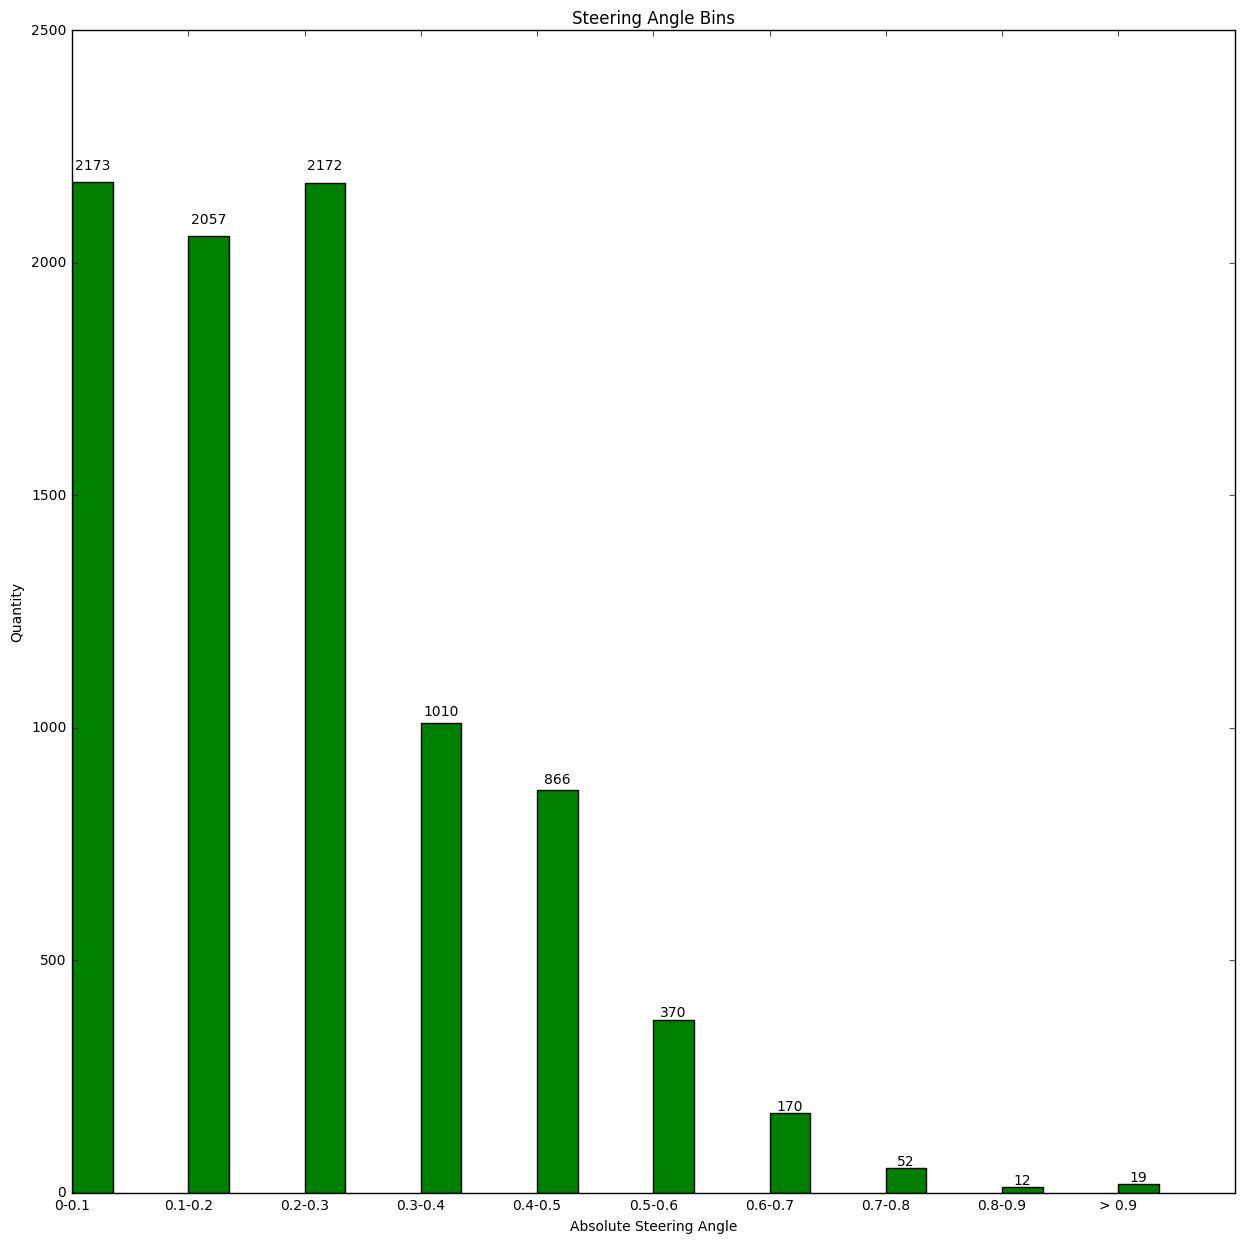

Total number of samples: 8901
Done


In [4]:
#Split data into training and validation data
def train_val_split(reader):
    
    train_data, val_data = train_test_split(
                reader,
                test_size=0.1,
                random_state=8499) 

    return (train_data, val_data)

# row[3] = center image steering angle
# row[7] = left image steering angle
# row[8] = right image steering angle
# row[9] = center image flip steering angle
# row[10] = left image flip steering angle
# row[11] = right image flip steering angle

# create a copy of new reader for appending new information
new_reader = copy.deepcopy(reader)

for row in new_reader:
    row.append(float(row[3]) + 0.25)
    row.append(float(row[3]) - 0.25)
    row.append(float(row[3]) * -1.0)
    row.append(float(row[3]) * -1.0 - 0.25)
    row.append(float(row[3]) * -1.0 + 0.25)
    
#Split data into training and validation data
train_data, val_data = train_val_split(new_reader)
prob_threshold = 0.8
img_rows, img_cols, ch = 66, 200, 3

# reinitialize data_types to 0
data_types = []
for i in range(10):
    data_types.append(0)

sample_count = 0
for row in train_data:
    
    if abs(float(row[3])) <= 0.1 and np.random.uniform() <= prob_threshold:
        continue
    else:
                
        flip_image = np.random.randint(2)
                
        if flip_image == 0:
            for i in [3,7,8]:
                if abs(float(row[i])) < 0.1:
                    data_types[0] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.1 and abs(float(row[i])) < 0.2:
                    data_types[1] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.2 and abs(float(row[i])) < 0.3:
                    data_types[2] += 1  
                    sample_count += 1
                elif abs(float(row[i])) > 0.3 and abs(float(row[i])) < 0.4:
                    data_types[3] += 1 
                    sample_count += 1
                elif abs(float(row[i])) > 0.4 and abs(float(row[i])) < 0.5:
                    data_types[4] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.5 and abs(float(row[i])) < 0.6:
                    data_types[5] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.6 and abs(float(row[i])) < 0.7:
                    data_types[6] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.7 and abs(float(row[i])) < 0.8:
                    data_types[7] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.8 and abs(float(row[i])) < 0.9:
                    data_types[8] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.9:
                    data_types[9] += 1
                    sample_count += 1

        else:
            for i in [9,10,11]:
                if abs(float(row[i])) < 0.1:
                    data_types[0] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.1 and abs(float(row[i])) < 0.2:
                    data_types[1] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.2 and abs(float(row[i])) < 0.3:
                    data_types[2] += 1  
                    sample_count += 1
                elif abs(float(row[i])) > 0.3 and abs(float(row[i])) < 0.4:
                    data_types[3] += 1 
                    sample_count += 1
                elif abs(float(row[i])) > 0.4 and abs(float(row[i])) < 0.5:
                    data_types[4] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.5 and abs(float(row[i])) < 0.6:
                    data_types[5] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.6 and abs(float(row[i])) < 0.7:
                    data_types[6] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.7 and abs(float(row[i])) < 0.8:
                    data_types[7] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.8 and abs(float(row[i])) < 0.9:
                    data_types[8] += 1
                    sample_count += 1
                elif abs(float(row[i])) > 0.9:
                    data_types[9] += 1
                    sample_count += 1
                    
                    
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

n_bin = len(data_types)

ind = np.arange(n_bin)
width = 0.35

bar1 = ax.bar(ind, data_types, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Quantity')
ax.set_title('Steering Angle Bins')
ax.set_xlabel('Absolute Steering Angle')
ax.set_xticks(ind)
ax.set_xticklabels(('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '> 0.9'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bar1)

plt.show() 

train_data_count = sample_count

print('Total number of samples:', sample_count)

print('Done')

## Step 4: Define image augmentation functions

_Note: Image augmentation functions below have been adapted from Vivek's excellent [post](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.7sw3ovxs6) on his project._

1. add_random_shadow function to train model in ignoring effects of shadows in image
2. augment_brightness_camera_images function to train model to drive in different lighting conditions
3. trans_image to translate images therefore simulating vehicle closer to left or right of road. Up down translation can also simulate the bounce of the vehicle. * Not used in current pipeline *

In [5]:
#Add random shadows to image for augmentation
#Reference from https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.7sw3ovxs6
def add_random_shadow(image):
    
    top_x = 320*np.random.uniform()
    top_y = 0
    bot_y = 160
    bot_x = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    
    Y_m, X_m = np.mgrid[0:image.shape[0],0:image.shape[1]]
    
    shadow_mask[((Y_m-top_y)*(bot_x-top_x) -(bot_y - top_y)*(X_m-top_x) >=0)]=1

    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

#Random increase or decrease brightness of image for augmentation
#Reference from https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.7sw3ovxs6
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(low=0.5, high=1.0)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# Not used in current pipeline
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

print('Done')

Done


## Step 5 : Define image processing function and function to create validation data

In [6]:
# Define augment_brightness_camera_images and add_random_shadow functions
# Resize image to 64 x 64 (vivek) or 66 x 200 (nvidia)

#Process image using augmentation functions
def process_image(image_data):
    shape = image_data.shape
    
    # augment brightness
    image_data = augment_brightness_camera_images(image_data)
    
    # add random shadows
    image_data = add_random_shadow(image_data)
    
    # crop top and bottom image to remove irrelevant image of sky and hood of car
    image = image_data[math.floor(shape[0]/5):shape[0]-22, 0:shape[1]]
    # image shape after croping is (106, 320, 3)
    
    # half image size to reduce training time. Dimension is kept especially in horizontal 
    # to train for minute steering angle values with each horizontal shifts in pixels
    image = cv2.resize(image, (img_cols, img_rows), interpolation = cv2.INTER_AREA)
    
    return image

#read left/right/center camera data and process image for validation
def val_data_create(data):
    
    X = []
    Y = []
    
    for row in data:
        if DATA_FOLDER == 'add_train':
            index = row[0].index('add_train')
            image = cv2.imread(row[0][index:])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            X.append(process_image(image))
            Y.append(float(row[3]))  
        elif DATA_FOLDER == 'data':
            # row[3] = center image steering angle
            image = cv2.imread('data/'+ row[0]) 
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
            X.append(process_image(image))
            Y.append(float(row[3])) 
                   
            # row[7] = left image steering angle
            imageleft = cv2.imread('data/' + row[1][1:]) 
            imageleft = cv2.cvtColor(imageleft, cv2.COLOR_BGR2RGB)
            X.append(process_image(imageleft))
            Y.append(float(row[7]))
            
            # row[8] = right image steering angle
            imageright = cv2.imread('data/' + row[2][1:]) 
            imageright = cv2.cvtColor(imageright, cv2.COLOR_BGR2RGB)
            X.append(process_image(imageright))
            Y.append(float(row[8]))
            
            # row[9] = center image flip steering angle
            image = cv2.imread('data/'+ row[0])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.flip(image, 1)
            X.append(process_image(image))
            Y.append(float(row[9])) 
            
            # row[10] = left image flip steering angle
            imageleft = cv2.imread('data/' + row[1][1:])
            imageleft = cv2.cvtColor(imageleft, cv2.COLOR_BGR2RGB)
            imageleft = cv2.flip(imageleft, 1)
            X.append(process_image(imageleft))
            Y.append(float(row[10]))

            # row[11] = right image flip steering angle
            imageright = cv2.imread('data/' + row[2][1:])
            imageright = cv2.cvtColor(imageright, cv2.COLOR_BGR2RGB)
            imageright = cv2.flip(imageright, 1)
            X.append(process_image(imageright))
            Y.append(float(row[11]))

    X = np.array(X)
    Y = np.array(Y)     

    return (X,Y)

print('Done')

Done


## Step 6 : Define python batch generator for loading of images

Left and right images are required to "teach" the model about recovering from the edges of the road. Importance is to avoid biasness as well during the feeding of image.

* batchGen : Randomly selects 1/6 images (L/R/C and flipped L/R/C) per row of data

In [7]:
#Python generator
#Read csv file in batches and passes to model for training
#Randomly selects 1/6 images per row of data
def batchGen(train_data, training_batch, prob_threshold):
    
    X_train = []
    Y_train = []
    
    while True:
               
        # row[3] = center image steering angle
        # row[7] = left image steering angle
        # row[8] = right image steering angle
        # row[9] = center image flip steering angle
        # row[10] = left image flip steering angle
        # row[11] = right image flip steering angle
        
        for row in train_data:
                
            if abs(float(row[3])) <= 0.1 and np.random.uniform() <= prob_threshold:
                continue
            else:
                
                image_selection = np.random.randint(6)
                
                if image_selection == 0:
                    # row[3] = center image steering angle
                    image = cv2.imread('data/'+ row[0])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    X_train.append(process_image(image))
                    Y_train.append(float(row[3]))  

                elif image_selection == 1:
                    # row[7] = left image steering angle
                    imageleft = cv2.imread('data/' + row[1][1:]) 
                    imageleft = cv2.cvtColor(imageleft, cv2.COLOR_BGR2RGB)
                    X_train.append(process_image(imageleft))
                    Y_train.append(float(row[7]))

                elif image_selection == 2:
                    # row[8] = right image steering angle
                    imageright = cv2.imread('data/' + row[2][1:]) 
                    imageright = cv2.cvtColor(imageright, cv2.COLOR_BGR2RGB)
                    X_train.append(process_image(imageright))
                    Y_train.append(float(row[8])) 

                elif image_selection == 3:
                    # row[9] = center image flip steering angle
                    image = cv2.imread('data/'+ row[0])
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.flip(image, 1)
                    X_train.append(process_image(image))
                    Y_train.append(float(row[9]))     

                elif image_selection == 4:
                    # row[10] = left image flip steering angle
                    imageleft = cv2.imread('data/' + row[1][1:])
                    imageleft = cv2.cvtColor(imageleft, cv2.COLOR_BGR2RGB)
                    imageleft = cv2.flip(imageleft, 1)
                    X_train.append(process_image(imageleft))
                    Y_train.append(float(row[10]))

                elif image_selection == 5:
                    # row[11] = right image flip steering angle
                    imageright = cv2.imread('data/' + row[2][1:]) 
                    imageright = cv2.cvtColor(imageright, cv2.COLOR_BGR2RGB)
                    imageright = cv2.flip(imageright, 1)
                    X_train.append(process_image(imageright))
                    Y_train.append(float(row[11])) 

            if len(X_train) == training_batch:
                X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
                yield (np.array(X_train), np.array(Y_train))
                X_train = []
                Y_train = []

            
print('Done')

Done


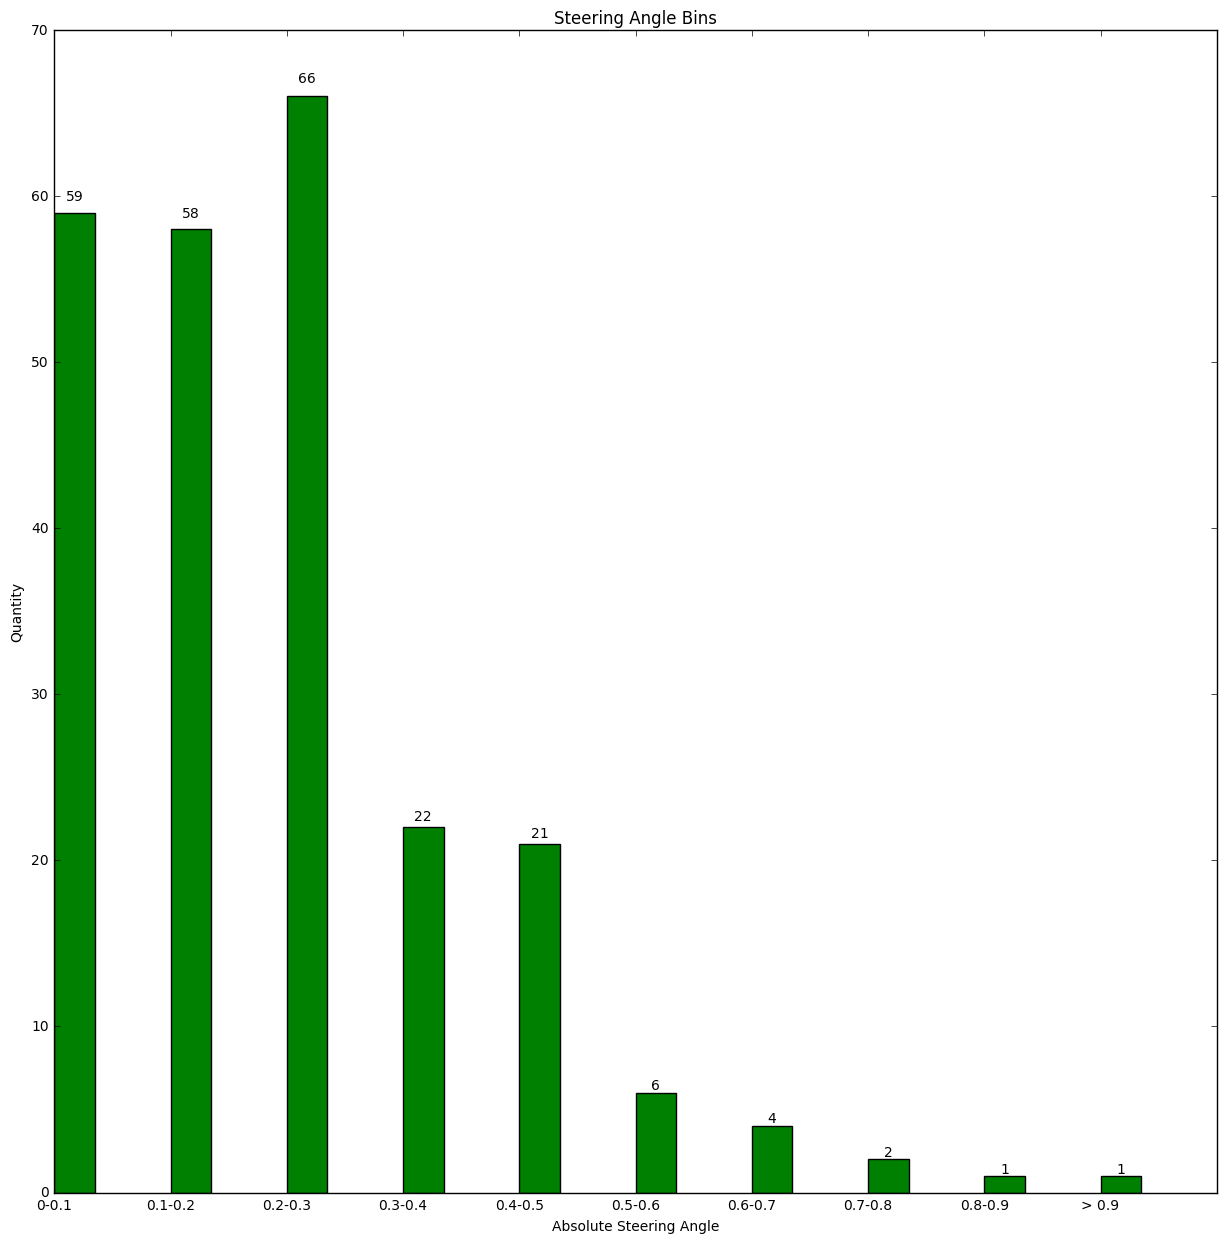

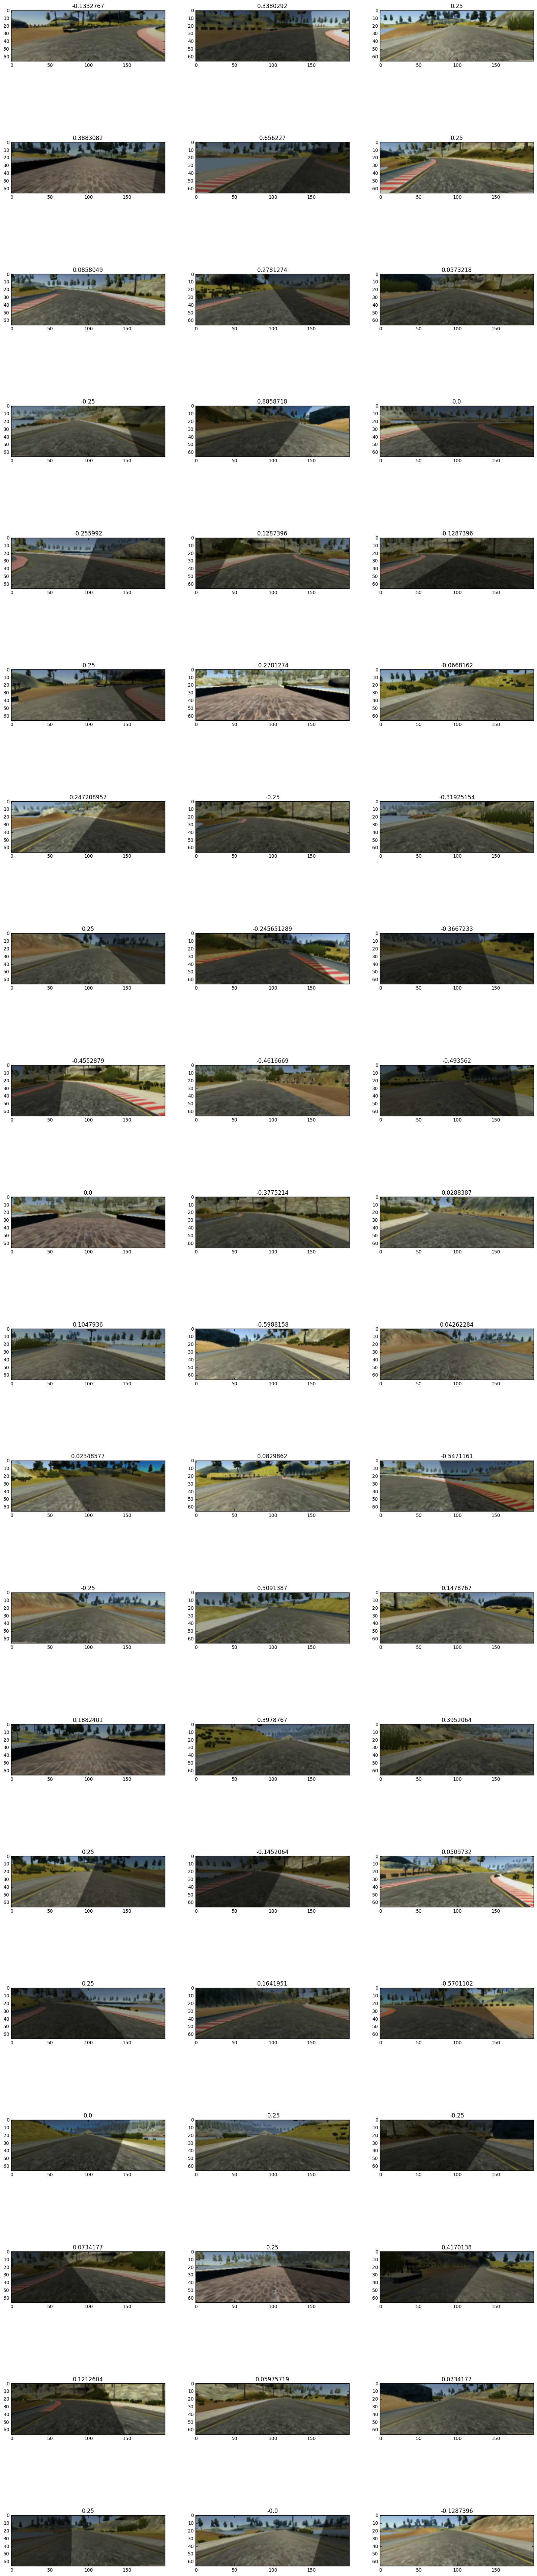

240


In [8]:
#Read image for validation
X_val, Y_val = val_data_create(val_data)

for xx, yy in batchGen(train_data, 240, prob_threshold):
    if np.random.randint(2) == 0:
        test_batchgen_x, test_batchgen_y = xx, yy
        break

# reinitialize data_types to 0
data_types = []
for i in range(10):
    data_types.append(0)

sample_count = 0
for value in test_batchgen_y:
    
    if abs(value) < 0.1:
        data_types[0] += 1
        sample_count += 1
    elif abs(value) > 0.1 and abs(value) < 0.2:
        data_types[1] += 1
        sample_count += 1
    elif abs(value) > 0.2 and abs(value) < 0.3:
        data_types[2] += 1  
        sample_count += 1
    elif abs(value) > 0.3 and abs(value) < 0.4:
        data_types[3] += 1 
        sample_count += 1
    elif abs(value) > 0.4 and abs(value) < 0.5:
        data_types[4] += 1
        sample_count += 1
    elif abs(value) > 0.5 and abs(value) < 0.6:
        data_types[5] += 1
        sample_count += 1
    elif abs(value) > 0.6 and abs(value) < 0.7:
        data_types[6] += 1
        sample_count += 1
    elif abs(value) > 0.7 and abs(value) < 0.8:
        data_types[7] += 1
        sample_count += 1
    elif abs(value) > 0.8 and abs(value) < 0.9:
        data_types[8] += 1
        sample_count += 1
    elif abs(value) > 0.9:
        data_types[9] += 1
        sample_count += 1

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

n_bin = len(data_types)

ind = np.arange(n_bin)
width = 0.35

bar1 = ax.bar(ind, data_types, width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Quantity')
ax.set_title('Steering Angle Bins')
ax.set_xlabel('Absolute Steering Angle')
ax.set_xticks(ind)
ax.set_xticklabels(('0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '> 0.9'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(bar1)

plt.show() 

# Sample images in a 11 x 4 plot
fig = plt.figure(figsize=(20, 100))

for i in range(60):
    fig.add_subplot(20, 3, i+1)
    #print(test_batchgen_x[i][0][0])
    plt.imshow(test_batchgen_x[i])
    plt.title(test_batchgen_y[i])

plt.show()

print(sample_count)

## Step 7 : Define function for model creation

Model available are models from 
* [Nvidia](http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) 
* Fellow Udacity's student Vivek's [model](https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.7sw3ovxs6)
* Model from [comma ai](https://github.com/commaai/research/blob/master/train_steering_model.py)
* vgg 16 pretrained [model](https://arxiv.org/pdf/1409.1556.pdf) with weights ported from keras.

*Exploration on resnet and inception are work in progress*

In [9]:
# Create model according to model selected in command line

def create_model(model_type, trainable = False):
    
    input_tensor = Input(shape=(img_rows, img_cols, ch))
    
    if MODEL_TYPE == 'vgg16':
        
        base_model = VGG16(include_top=False, weights='imagenet')
        
        # first: train only the top layers (which were randomly initialized)
        # i.e. freeze all vgg16 layers
        for layer in base_model.layers:
            layer.trainable = trainable
        
        model = Sequential()
        model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
        model.add(base_model)
        x = model.output
        x = Activation('relu')(x)
        x = Flatten()(x)
        x = Dense(512)(x)
        x = Activation('relu')(x)
        x = Dense(1)(x)
        model = Model(model.input, x)   
       
    elif MODEL_TYPE == 'comma_ai':
        model = Sequential()
        model.add(Lambda(lambda x: x/127.5 - 1.,
                    input_shape=input_shape,
                    output_shape=input_shape))
        model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(ELU())
        model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
        model.add(Flatten())
        model.add(Dropout(.2))
        model.add(ELU())
        model.add(Dense(512))
        model.add(Dropout(.5))
        model.add(ELU())
        model.add(Dense(1))
    
    elif MODEL_TYPE == 'nvidia':
        
        # number of convolutional filters to use
        nb_filters1 = 24
        nb_filters2 = 36
        nb_filters3 = 48
        nb_filters4 = 64
        nb_filters5 = 64
        
        # number of fully connected layers
        fc1 = 1164
        fc2 = 100
        fc3 = 50
        fc4 = 10

        # convolution kernel size
        kernel_size1 = (5, 5)
        kernel_size2 = (3, 3)
        
        model = Sequential()
        model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
        
        model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                                border_mode='valid', init = 'normal', subsample=(2, 2)))
        model.add(ELU())
        model.add(Convolution2D(nb_filters2, kernel_size1[0], kernel_size1[1],
                                border_mode='valid', init = 'normal', subsample=(2, 2)))
        model.add(ELU())
        model.add(Convolution2D(nb_filters3, kernel_size1[0], kernel_size1[1],
                                        border_mode='valid', init = 'normal', subsample=(2, 2)))
        model.add(ELU())
        model.add(Convolution2D(nb_filters4, kernel_size2[0], kernel_size2[1],
                                        border_mode='valid', init = 'normal', subsample=(1, 1)))
        model.add(ELU()) 
        model.add(Convolution2D(nb_filters5, kernel_size2[0], kernel_size2[1],
                                        border_mode='valid', init = 'normal', subsample=(1, 1)))
        model.add(ELU())         
        model.add(Flatten())
        model.add(Dense(fc1, init = 'normal'))
        model.add(ELU())
        model.add(Dense(fc2, init = 'normal'))
        model.add(ELU())
        model.add(Dense(fc3, init = 'normal'))
        model.add(ELU())  
        model.add(Dense(fc4, init = 'normal'))
        model.add(ELU())  
        model.add(Dense(1, init = 'normal'))                 
       
    elif MODEL_TYPE == 'vivek':
        
        # number of convolutional filters to use
        nb_filters1 = 32
        nb_filters2 = 64
        nb_filters3 = 128

        # number of fully connected layers
        fc1 = 512
        fc2 = 64
        fc3 = 16
        
        # size of pooling area for max pooling
        pool_size = (2, 2)
        
        # convolution kernel size
        kernel_size = (3, 3)
        
        model = Sequential()
        model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
        

        # 1x1 convolution
        model.add(Convolution2D(3, 1, 1, border_mode='valid', init = 'normal',
                                        input_shape=input_shape))        
        
        model.add(Convolution2D(nb_filters1, kernel_size[0], kernel_size[1],
                                border_mode='valid', init = 'normal',
                                input_shape=input_shape))
        model.add(Convolution2D(nb_filters1, kernel_size[0], kernel_size[1],
                                border_mode='valid', init = 'normal',
                                input_shape=input_shape))   
        model.add(MaxPooling2D(pool_size=pool_size))  
        model.add(Dropout(.5))                                               
        model.add(ELU())
        
        model.add(Convolution2D(nb_filters2, kernel_size[0], kernel_size[1],
                                border_mode='valid', init = 'normal',
                                input_shape=input_shape))
        model.add(Convolution2D(nb_filters2, kernel_size[0], kernel_size[1],
                                border_mode='valid', init = 'normal',
                                input_shape=input_shape))  
        model.add(MaxPooling2D(pool_size=pool_size))   
        model.add(Dropout(.5))                                               
        model.add(ELU())
        
        
        model.add(Convolution2D(nb_filters3, kernel_size[0], kernel_size[1],
                                        border_mode='valid', init = 'normal',
                                        input_shape=input_shape))
        model.add(Convolution2D(nb_filters3, kernel_size[0], kernel_size[1],
                                        border_mode='valid', init = 'normal',
                                        input_shape=input_shape))        
        model.add(MaxPooling2D(pool_size=pool_size))  
        model.add(Dropout(.5))                                               
        model.add(ELU())
        
        model.add(Flatten())
        model.add(Dense(fc1, init = 'normal'))
        model.add(Dropout(.5))                                                       
        model.add(ELU())
        model.add(Dense(fc2, init = 'normal'))
        model.add(Dropout(.5))                                                       
        model.add(ELU())
        model.add(Dense(fc3, init = 'normal'))
        model.add(Dropout(.5))                                                       
        model.add(ELU())  
        model.add(Dense(1, init = 'normal'))               
    """
    elif MODEL_TYPE == 'res':
        model = Sequential()
        model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
        model.add(ResNet50(include_top=False, weights='imagenet'))
        x = model.output
        x = Flatten()(x)
        x = Dense(512)(x)
        x = Activation('relu')(x)
        x = Dense(1)(x)
        model = Model(model.input, x)        
    elif MODEL_TYPE == 'inception':
        model = Sequential()
        model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=input_shape))
        model.add(InceptionV3(include_top=False, weights='imagenet'))
        x = model.output
        x = Flatten()(x)
        x = Dense(512)(x)
        x = Activation('relu')(x)
        x = Dense(1)(x)
        model = Model(model.input, x)
    """  
    return model

print('Done')

Done


## Step 8 : Train Model

To begin training, first initialize the model that you want to train and also the type of training to perform

Current selectable models include
* vivek / nvidia / vgg16 / comma_ai

Type of training
* new : Training from scratch. Training progress and validation results will be plotted on graph
* reload : Reload previously trained model


Training nvidia model...
Training Type : new
Number of training data:  8901
Number of validation data:  4824
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       elu_1[0][0]     

/home/dennis/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


9120/8901 [==============================] - 26s - loss: 0.0653 - acc: 0.0870 - val_loss: 0.0470 - val_acc: 0.1828
Epoch 2/30
9120/8901 [==============================] - 25s - loss: 0.0489 - acc: 0.0916 - val_loss: 0.0389 - val_acc: 0.1828
Epoch 3/30
9120/8901 [==============================] - 25s - loss: 0.0408 - acc: 0.0862 - val_loss: 0.0350 - val_acc: 0.1828
Epoch 4/30
9120/8901 [==============================] - 25s - loss: 0.0376 - acc: 0.0843 - val_loss: 0.0319 - val_acc: 0.1828
Epoch 5/30
9120/8901 [==============================] - 25s - loss: 0.0356 - acc: 0.0863 - val_loss: 0.0300 - val_acc: 0.1828
Epoch 6/30
9120/8901 [==============================] - 25s - loss: 0.0330 - acc: 0.0851 - val_loss: 0.0291 - val_acc: 0.1828
Epoch 7/30
9120/8901 [==============================] - 25s - loss: 0.0320 - acc: 0.0865 - val_loss: 0.0276 - val_acc: 0.1828
Epoch 8/30
9120/8901 [==============================] - 25s - loss: 0.0306 - acc: 0.0890 - val_loss: 0.0263 - val_acc: 0.1828
Epo

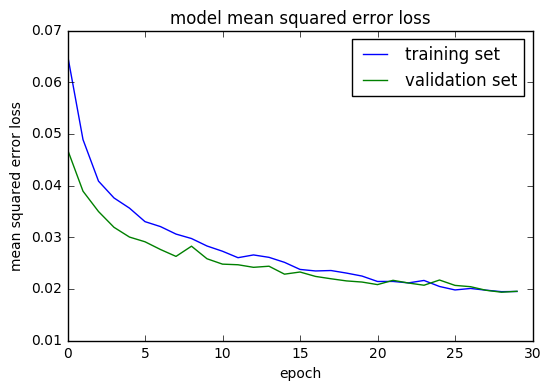

Done


In [10]:
# Initialize variable for the type of model to be run
# Options : nvidia / vivek / vgg16 / comma_ai
MODEL_TYPE = 'nvidia'
print('Training ' + MODEL_TYPE + ' model...')

# Determine type of training to perform as described below
# Options 
## new : Initial exploration of training progress and validation results with results plotted on graph
## reload : Reload previously trained model
TRAINING_TYPE = 'new'
print('Training Type : ' + TRAINING_TYPE)

# Training and validation data size has been pre-determined at earlier step after splitting data into training and validation
# and factoring in random 80% reduction of small steering angles
print('Number of training data: ', train_data_count)
print('Number of validation data: ', len(X_val))

# Final output image dimensions to adjust according to the model type used
if MODEL_TYPE == 'vivek':
    img_rows, img_cols, ch = 64, 64, 3
elif MODEL_TYPE == 'nvidia':
    img_rows, img_cols, ch = 66, 200, 3
elif MODEL_TYPE == 'comma_ai':
    img_rows, img_cols, ch = 160, 320, 3
else:
    img_rows, img_cols, ch = 66, 200, 3
input_shape = (img_rows, img_cols, ch)

# Create validation data with the right image size
X_val, Y_val = val_data_create(val_data)

batch_size = 240

#Check command line input for new training or reload training data
if TRAINING_TYPE == 'new':
    model = create_model(MODEL_TYPE)  
    model.summary()
elif TRAINING_TYPE == 'reload':
    with open(MODEL_TYPE + '_model/' + MODEL_TYPE + str(epoch) + '.json') as json_data:
        
        d = json.load(json_data)
    
        from keras.models import model_from_json
        model = model_from_json(d)
        model.load_weights(MODEL_TYPE + '_model/' + MODEL_TYPE + str(epoch) + '.h5')
    model.summary()

#Using Adam optimizer with learning rate of 0.0001
adam = Adam(lr=0.0001)
model.compile(loss='mse',
              optimizer=adam,
              metrics=['accuracy'])

class My_Callback(Callback):
    
    def __init__(self, MODEL_TYPE):
        self.model_type = MODEL_TYPE
        self.counter = 0
    
    def on_epoch_end(self, epoch, logs={}):
        f = open(self.model_type + '_model/' + self.model_type + str(self.counter) + '.json', 'w') 
        f.write(json.dumps(model.to_json()))
        f.close()
        model.save_weights(self.model_type + '_model/' + self.model_type + str(self.counter)  + '.h5')
        self.counter += 1
        return

mycallback = My_Callback(MODEL_TYPE)

#Begin training

epoch = 30

print('Begin training...')
print('Probability Threshold: ', prob_threshold)

if not os.path.exists(MODEL_TYPE + '_model'):
    os.makedirs(MODEL_TYPE + '_model')
    print(MODEL_TYPE + '_model folder created')

history_object = model.fit_generator(batchGen(train_data, batch_size, prob_threshold),train_data_count, epoch ,
              verbose=1, validation_data=(X_val, Y_val), callbacks=[mycallback])    

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

print('Done')

## Visualize Models at final convolution layer

Ideas for implementation of visualization were gotten from [dolaameng](https://github.com/dolaameng/Udacity-SDC_Behavior-Cloning/blob/master/understand_model.ipynb) where he implemented a ** _cheap approximation_ ** of visualizing the convolution network.

For more sophiticated implementation of deconvolution, one may refer to this [paper](https://arxiv.org/pdf/1311.2901.pdf) Visualizing and Understanding Convolutional Networks.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

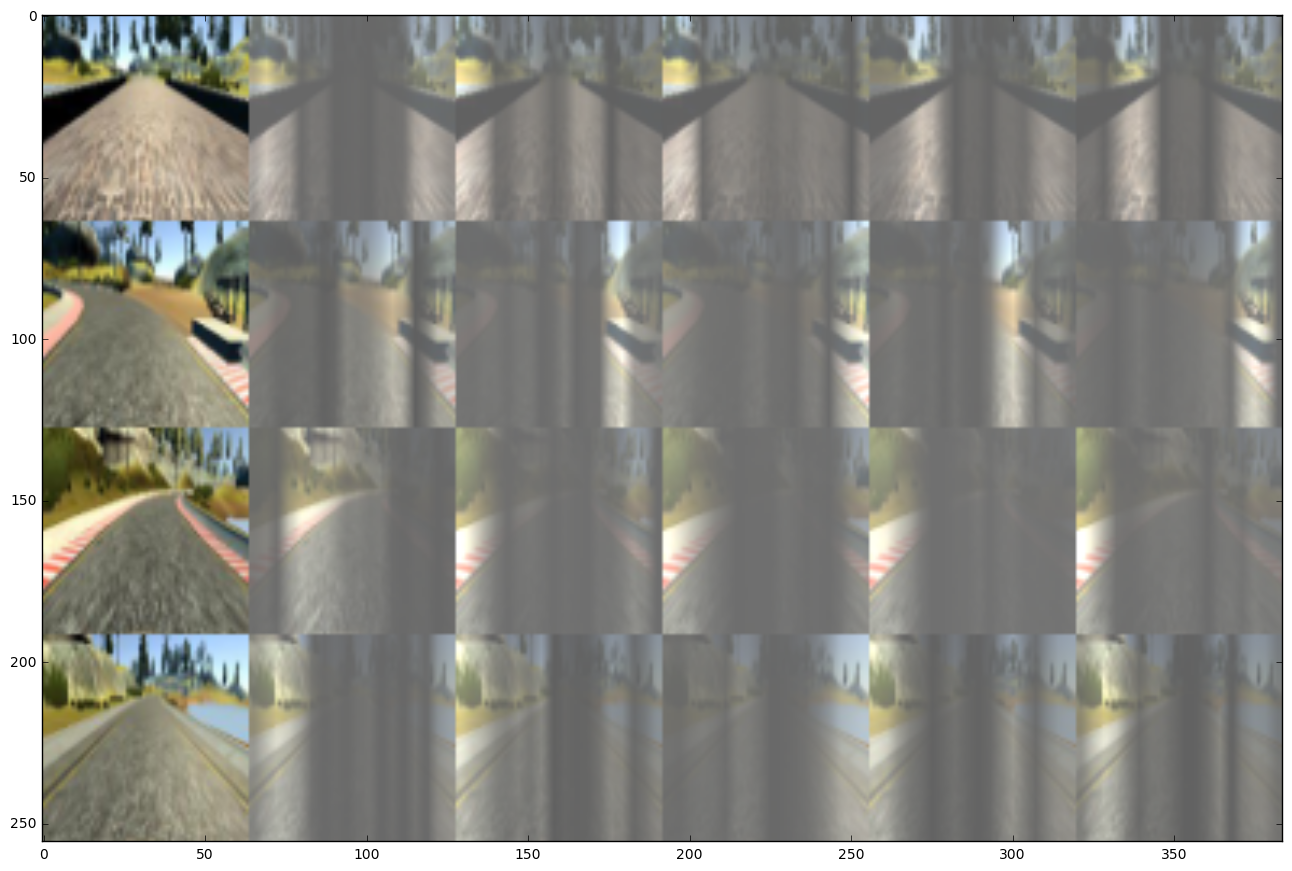

Done


In [11]:
from scipy.misc import imresize
import keras.backend as K

MODEL_TYPE = 'nvidia'
epoch = 23
topn = 5

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Final output image dimensions to adjust according to the model type used
if MODEL_TYPE == 'vivek':
    img_rows, img_cols, ch = 64, 64, 3
elif MODEL_TYPE == 'nvidia':
    img_rows, img_cols, ch = 66, 200, 3
elif MODEL_TYPE == 'comma_ai':
    img_rows, img_cols, ch = 160, 320, 3
else:
    img_rows, img_cols, ch = 66, 200, 3
input_shape = (img_rows, img_cols, ch)

sample_image_path = ['data/IMG/center_2016_12_01_13_30_48_404.jpg', 
                     'data/IMG/center_2016_12_01_13_31_15_106.jpg',
                    'data/IMG/center_2016_12_01_13_33_06_005.jpg',
                    'data/IMG/center_2016_12_01_13_33_26_557.jpg']

with open(MODEL_TYPE + '_model/' + MODEL_TYPE + str(epoch) + '.json') as json_data:
        
    d = json.load(json_data)
    
    from keras.models import model_from_json
    model = model_from_json(d)
    model.load_weights(MODEL_TYPE + '_model/' + MODEL_TYPE + str(epoch) + '.h5')
    model.summary()
    
    
    # Find target layer for extraction
    # View convolution result prior to flattening
    for layer in model.layers:
        
        if layer.name.startswith("flatten"):
            break
        
        target_layer = layer
        
    print(target_layer.name)
    
    # Process image for feed into model
    processed_raw_imgs = []
    for image in sample_image_path:
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[math.floor(image.shape[0]/5):image.shape[0]-22, 0:image.shape[1]]
        image = cv2.resize(image, (img_cols, img_rows), interpolation = cv2.INTER_AREA)        
        
        processed_raw_imgs.append(image)
    processed_raw_imgs = np.array(processed_raw_imgs)
    
    # build a new model to output the certain layer 
    visual_model = Model(model.input, model.get_layer(target_layer.name).output)
    
    layer_output = visual_model.predict(processed_raw_imgs)
    print('Target layer output shape: ', layer_output.shape)
    
    # bigger absolute values of outputs indicate important pixels
    layer_output = np.abs(layer_output)
    
    # scale output
    layer_output = (layer_output - layer_output.min()) / (layer_output.max() - layer_output.min())
    
    
    h, w = 64, 64  

    # find top filters for each image and combine them with original image
    plot_img = np.zeros((len(processed_raw_imgs)*h, (topn+1)*w, 3))
        
    for i, raw_img in enumerate(processed_raw_imgs):
        output = layer_output[i]#np.abs(layer_output[i, ...])
        # filter scores as mean absolute values of activations
        filter_scores = output.reshape((-1, output.shape[-1])).max(axis=0)
        topn_filters = np.argsort(filter_scores)[-topn:]
        
        raw_img = cv2.resize(raw_img, (w, h), interpolation = cv2.INTER_AREA)  
        plot_img[i*h:(i*h+h), :w, :] = raw_img

        for n, ifilter in enumerate(topn_filters):
            mask = imresize(output[:, :, ifilter], (h, w))
            filter_img = raw_img.astype(np.float32) * np.expand_dims(mask, -1)
            plot_img[i*h:(i*h+h), (n+1)*w:((n+1)*w+w), :] = cv2.resize(deprocess_image(filter_img), (w, h), interpolation = cv2.INTER_AREA) 
    
    plt.figure(figsize=(16, 16))
    plt.imshow(plot_img.astype(np.uint8))
    
    plt.show()
    
    print('Done')
        